# Access ICESat-2 Data

University of Washington ICESat-2 Hackweek | June 2019 <br>
originally written by Amy Steiker @asteiker <br>
adjusted for #glaciersat2 by Caitlyn Florentine @cflorentine <br>

---
## Workflow
1. Geting started
2. Earthdata
3. ICESat-2 data
4. Subsetting time and space
5. Query
6. Select services
7. API parameters
8. Request data

#### Abbreviations
National Snow and Ice Data Center ([NSIDC](https://nsidc.org/))<br>
Distributed Active Archive Center (DAAC) <br>
Application Programming Interface (API) <br>
Global Land Ice Measurments from Space ([GLIMS](https://www.glims.org/))<br>
Common Metadata Repository ([CMR](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html "CMR API documentation")) <br>

#### Check that the current working directory contains:
Glacier KML that lives in the same directory as this Jupyter notebook.

## 1. Getting started
Import all the necessary libraries.

In [50]:
import requests
import getpass
import socket
import json
import zipfile
import io
import math
import os
import shutil
import pprint
import time
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
import h5py
import re
# To read KML files with geopandas, enable KML support in fiona 
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
from shapely.geometry import Polygon, mapping
from shapely.geometry.polygon import orient
from statistics import mean
from requests.auth import HTTPBasicAuth

## 2. Earthdata

Generate a token needed for accessing data using Earthdata Login. If you do not already have an Earthdata Login account register [here](http://urs.earthdata.nasa.gov). <br>

In [51]:
uid = 'cflorentine' #enter your Earthdata username
email = 'cflorentine@usgs.gov' #enter your email
pswd = getpass.getpass('Earthdata Login password: ')

Earthdata Login password:  ···········


Request token from Common Metadata Repository using Earthdata credentials

In [52]:
token_api_url = 'https://cmr.earthdata.nasa.gov/legacy-services/rest/tokens'
hostname = socket.gethostname()
ip = socket.gethostbyname(hostname)

data = {
    'token': {
        'username': uid,
        'password': pswd,
        'client_id': 'NSIDC_client_id',
        'user_ip_address': ip
    }
}
headers={'Accept': 'application/json'}
response = requests.post(token_api_url, json=data, headers=headers)
token = json.loads(response.content)['token']['id']
print(token)
#example token = 4351E4A7-9907-AEA1-82B3-FE2A36C88659

A51CBA50-8122-6C2D-BBA0-FD8E99E7B8E1


## 3. ICESat-2 data

Access ATLAS/ICESat-2 L3A Land Ice Height (ATL06) data!!! See NSIDC [data](https://nsidc.org/data/atl06), [online user guide](https://nsidc.org/data/atl06?qt-data_set_tabs=3#qt-data_set_tabs), and [data dictionary](https://nsidc.org/sites/nsidc.org/files/technical-references/ATL06-data-dictionary-v001.pdf) links for documentation. </br>

Inspect the high-level ICESat-2 ATL06 metadata.

In [53]:
# Get json response from CMR collection metadata
short_name = 'ATL06'
params = {
    'short_name': short_name
}

cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
response = requests.get(cmr_collections_url, params=params)
results = json.loads(response.content)
pprint.pprint(results)

{'feed': {'entry': [{'archive_center': 'NASA NSIDC DAAC',
                     'associations': {'services': ['S1568899363-NSIDC_ECS',
                                                   'S1613689509-NSIDC_ECS',
                                                   'S1613669681-NSIDC_ECS']},
                     'boxes': ['-90 -180 90 180'],
                     'browse_flag': False,
                     'coordinate_system': 'CARTESIAN',
                     'data_center': 'NSIDC_ECS',
                     'dataset_id': 'ATLAS/ICESat-2 L3A Land Ice Height V001',
                     'has_formats': True,
                     'has_spatial_subsetting': True,
                     'has_temporal_subsetting': True,
                     'has_transforms': False,
                     'has_variables': True,
                     'id': 'C1511847675-NSIDC_ECS',
                     'links': [{'href': 'https://n5eil01u.ecs.nsidc.org/ATLAS/ATL06.001/',
                                'hreflang': 'en-US',
 

There may be cases where more than one ICESat-2 data version exists. Let's make sure we have the most recent version:

In [54]:
versions = [i['version_id'] for i in results['feed']['entry']]
latest_version = max(versions)
print(latest_version)

001


## 4. Subsetting time and space
To subset ICESat-2 data we will set the time range of interest manually. Then we will define the area of interest using the glacier KML file.

#### 4.1. Define the time of interest

In [58]:
start_date = '2018-10-01'
start_time = '00:00:00'
end_date = '2019-03-01'
end_time = '23:59:59'

temporal = start_date + 'T' + start_time + 'Z' + ',' + end_date + 'T' + end_time + 'Z'
print(temporal)

2018-10-01T00:00:00Z,2019-03-01T23:59:59Z


#### 4.2. Define the area of interest

In [92]:
import os
kml_filepath = os.getcwd()+'/taku_polygon.kml'
gdf = gpd.read_file(kml_filepath) #GeoDataFrame object
# gdf.head()

Visualize the glacier polygon we just imported to make sure all is good.

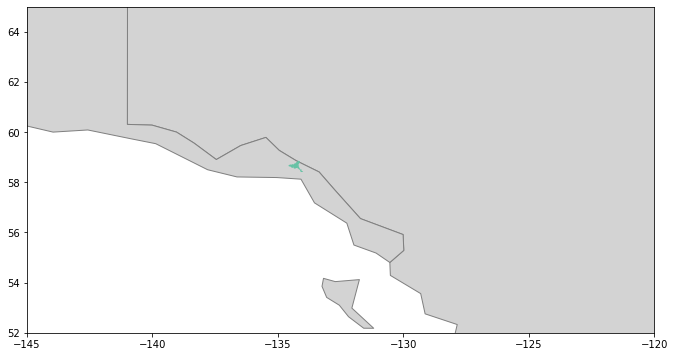

In [79]:
%matplotlib inline

# Load "Natural Earth” countries dataset, bundled with GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Overlay glacier outline
f, ax = plt.subplots(1, figsize=(12, 6))
world.plot(ax=ax, facecolor='lightgray', edgecolor='gray')
gdf.plot(ax=ax, cmap='Set2')
ax.set_ylim([52,65]) #adjust to frame glacier
ax.set_xlim([-145,-120]);

Convert the geopandas GeoDataFrame object to input readable by CMR.

In [80]:
#Integer position based indexing of GeoDataFrame object to get it into a shapeply geometry object.
poly = gdf.iloc[0].geometry

# Simplify polygon. The larger the tolerance value, the more simplified the polygon.
poly = poly.simplify(0.05, preserve_topology=False)

# Orient counter-clockwise
poly = orient(poly, sign=1.0)

print(poly)

#Format dictionary to polygon coordinate pairs for CMR polygon filtering
polygon = ','.join([str(c) for xy in zip(*poly.exterior.coords.xy) for c in xy])

# aoi value used for CMR params below
aoi = '3'

POLYGON Z ((-134.140369927 58.84756066000006 0, -134.5933307 58.64991417900006 0, -134.4530106449999 58.57874420000007 0, -134.357760661 58.62099421600005 0, -134.349790619 58.54857421700007 0, -134.191650618 58.57922424100008 0, -134.090664557 58.41642458200005 0, -134.007041547 58.42257706900006 0, -134.214740666 58.65846423700003 0, -134.140369927 58.84756066000006 0))


Now our coordinate pairs are ready for CMR.

## 5. Query

Populate search query dictionaries based on spatial and temporal inputs. 

In [81]:
#Create CMR parameters used for granule search. Modify params depending on bounding_box or polygon input.

# if aoi == '1':
# # bounding box input:
#     params = {
#     'short_name': short_name,
#     'version': latest_version,
#     'temporal': temporal,
#     'page_size': 100,
#     'page_num': 1,
#     'bounding_box': bounding_box
#     }
# else:
    
# If polygon input (either via coordinate pairs or shapefile/KML/KMZ):
    params = {
    'short_name': short_name,
    'version': latest_version,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1,
    'polygon': polygon,
    }

# print('CMR search parameters: ', params)

Next, determine data volume over the glacier by:
1. inputing the parameter dictionary to the CMR granule search.
2. querying all granules that meet the criteria based on the granule metadata.
3. printing the number of granules returned.

In [82]:
# Query number of granules using our (paging over results)

granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'

granules = []
while True:
    response = requests.get(granule_search_url, params=params, headers=headers)
    results = json.loads(response.content)

    if len(results['feed']['entry']) == 0:
        # Out of results, so break out of loop
        break

    # Collect results and increment page_num
    granules.extend(results['feed']['entry'])
    params['page_num'] += 1

    
# Get number of granules over my area and time of interest
len(granules)


9

Now query the average size of those granules. 

In [83]:
granule_sizes = [float(granule['granule_size']) for granule in granules]
mean(granule_sizes) # average size of granules in MB

6.599101808322223

As well as the total volume.

In [84]:
sum(granule_sizes) # total volume in MB

59.391916274900005

## 6. Select services 

Next we will interact with the service capability to gather and select customization options. 

First, query the service capability URL.

In [85]:
from xml.etree import ElementTree as ET

capability_url = f'https://n5eil02u.ecs.nsidc.org/egi/capabilities/{short_name}.{latest_version}.xml'

print(capability_url)

https://n5eil02u.ecs.nsidc.org/egi/capabilities/ATL06.001.xml


All of NSIDC's service endpoints are behind the NASA Earthdata Login. Therefore we need to create a session to store cookies and pass Earthdata Login credentials.

In [86]:
session = requests.session() #create session
s = session.get(capability_url)
response = session.get(s.url,auth=(uid,pswd))

root = ET.fromstring(response.content) #package to grab url content

Last, we collect service information lists from the service capability XML.

In [68]:
# collect lists with each service option

subagent = [subset_agent.attrib for subset_agent in root.iter('SubsetAgent')]

# variable subsetting
variables = [SubsetVariable.attrib for SubsetVariable in root.iter('SubsetVariable')]  
variables_raw = [variables[i]['value'] for i in range(len(variables))]
variables_join = [''.join(('/',v)) if v.startswith('/') == False else v for v in variables_raw] 
variable_vals = [v.replace(':', '/') for v in variables_join]

# reformatting
formats = [Format.attrib for Format in root.iter('Format')]
format_vals = [formats[i]['value'] for i in range(len(formats))]
format_vals.remove('')

# reprojection only applicable on ICESat-2 L3B products, yet to be available. 

# reformatting options that support reprojection
normalproj = [Projections.attrib for Projections in root.iter('Projections')]
normalproj_vals = []
normalproj_vals.append(normalproj[0]['normalProj'])
format_proj = normalproj_vals[0].split(',')
format_proj.remove('')
format_proj.append('No reformatting')

#reprojection options
projections = [Projection.attrib for Projection in root.iter('Projection')]
proj_vals = []
for i in range(len(projections)):
    if (projections[i]['value']) != 'NO_CHANGE' :
        proj_vals.append(projections[i]['value'])
        
# reformatting options that do not support reprojection
no_proj = [i for i in format_vals if i not in format_proj]

## 7. API parameters

Now that we have lists of each service option we can inspect subsetting variables that are used for our NSIDC API request. 

For example, we can make sure the time subset looks right.

In [87]:
# Temporal subsetting KVP

timevar = start_date + 'T' + start_time + ',' + end_date + 'T' + end_time
print(timevar)

2018-10-01T00:00:00,2019-03-01T23:59:59


Or we can explore the `variable_vals` list we gathered from the capabilities URL. 

In [88]:
len(variable_vals)
# pprint.pprint(variable_vals) #print the entire variable list

627

Yikes! That is a lot of variables. Let's only grab the ones we want.

Enter only ones we want separated by comma using the `coverage` key. 

**TIP** *: All forward slashes need to be included to indicate HDF group hierarchy.*

In [70]:
coverage = '/ancillary_data/atlas_sdp_gps_epoch,\
/gt1l/land_ice_segments/atl06_quality_summary,\
/gt1l/land_ice_segments/delta_time,\
/gt1l/land_ice_segments/h_li,\
/gt1l/land_ice_segments/h_li_sigma,\
/gt1l/land_ice_segments/latitude,\
/gt1l/land_ice_segments/longitude,\
/gt1l/land_ice_segments/segment_id,\
/gt1l/land_ice_segments/sigma_geo_h,\
/gt1r/land_ice_segments/atl06_quality_summary,\
/gt1r/land_ice_segments/delta_time,\
/gt1r/land_ice_segments/h_li,\
/gt1r/land_ice_segments/h_li_sigma,\
/gt1r/land_ice_segments/latitude,\
/gt1r/land_ice_segments/longitude,\
/gt1r/land_ice_segments/segment_id,\
/gt1r/land_ice_segments/sigma_geo_h,\
/gt2l/land_ice_segments/atl06_quality_summary,\
/gt2l/land_ice_segments/delta_time,\
/gt2l/land_ice_segments/h_li,\
/gt2l/land_ice_segments/h_li_sigma,\
/gt2l/land_ice_segments/latitude,\
/gt2l/land_ice_segments/longitude,\
/gt2l/land_ice_segments/segment_id,\
/gt2l/land_ice_segments/sigma_geo_h,\
/gt2r/land_ice_segments/atl06_quality_summary,\
/gt2r/land_ice_segments/delta_time,\
/gt2r/land_ice_segments/h_li,\
/gt2r/land_ice_segments/h_li_sigma,\
/gt2r/land_ice_segments/latitude,\
/gt2r/land_ice_segments/longitude,\
/gt2r/land_ice_segments/segment_id,\
/gt2r/land_ice_segments/sigma_geo_h,\
/gt3l/land_ice_segments/atl06_quality_summary,\
/gt3l/land_ice_segments/delta_time,\
/gt3l/land_ice_segments/h_li,\
/gt3l/land_ice_segments/h_li_sigma,\
/gt3l/land_ice_segments/latitude,\
/gt3l/land_ice_segments/longitude,\
/gt3l/land_ice_segments/segment_id,\
/gt3l/land_ice_segments/sigma_geo_h,\
/gt3r/land_ice_segments/atl06_quality_summary,\
/gt3r/land_ice_segments/delta_time,\
/gt3r/land_ice_segments/h_li,\
/gt3r/land_ice_segments/h_li_sigma,\
/gt3r/land_ice_segments/latitude,\
/gt3r/land_ice_segments/longitude,\
/gt3r/land_ice_segments/segment_id,\
/gt3r/land_ice_segments/sigma_geo_h,\
/orbit_info/cycle_number,\
/orbit_info/rgt,\
/orbit_info/orbit_number' 

## 7. Request data

Finally we are ready to request data from the NSIDC data access API.

1. Set the NSIDC data access base URL.
2. Set the number of granules requested per order.
3. Determine the number of pages.
4. Set the loop requests by this value.

In [89]:
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'
page_size = 10 #number of granules per order
page_num = math.ceil(len(granules)/page_size)
print(page_num)
request_mode = 'async'

1


Create a new dictionary of NSIDC API key-value-pairs (KVPs) for the request. 

In [56]:
# subset_params = {
#     'short_name': short_name, 
#     'version': latest_version, 
#     'temporal': temporal, 
#     'time': timevar, 
#     'polygon': polygon, 
#     'Coverage': coverage, 
#     'request_mode': request_mode, 
#     'page_size': page_size,  
#     'token': token, 
#     'email': email, 
#     }
# print(subset_params)

{'short_name': 'ATL06', 'version': '001', 'temporal': '2018-10-01T00:00:00Z,2019-03-01T23:59:59Z', 'time': '2018-10-01T00:00:00,2019-03-01T23:59:59', 'polygon': '-134.140369927,58.84756066000006,-134.5933307,58.64991417900006,-134.4530106449999,58.57874420000007,-134.357760661,58.62099421600005,-134.349790619,58.54857421700007,-134.191650618,58.57922424100008,-134.090664557,58.41642458200005,-134.007041547,58.42257706900006,-134.214740666,58.65846423700003,-134.140369927,58.84756066000006', 'Coverage': '/ancillary_data/atlas_sdp_gps_epoch,/gt1l/land_ice_segments/atl06_quality_summary,/gt1l/land_ice_segments/delta_time,/gt1l/land_ice_segments/h_li,/gt1l/land_ice_segments/h_li_sigma,/gt1l/land_ice_segments/latitude,/gt1l/land_ice_segments/longitude,/gt1l/land_ice_segments/segment_id,/gt1l/land_ice_segments/sigma_geo_h,/gt1r/land_ice_segments/atl06_quality_summary,/gt1r/land_ice_segments/delta_time,/gt1r/land_ice_segments/h_li,/gt1r/land_ice_segments/h_li_sigma,/gt1r/land_ice_segments/lat

#### We'll request the same data but without any subsetting services applied. Let's create another request parameter dictionary with the `time` and `coverage` service keys removed, and we'll add `agent=NO` instead.

In [90]:
request_params = {
    'short_name': short_name, 
    'version': latest_version, 
    'temporal': temporal, 
    'polygon': polygon, 
    'agent' : 'NO',
    'include_meta' : 'Y',
    'request_mode': request_mode, 
    'page_size': page_size,  
    'token': token, 
    'email': email, 
    }

# print(request_params)

Ready? Now we download subset ICESat-2 data to this notebook directory in a new output folder. The progress of each order will be reported. 

In [93]:
path = str(os.getcwd() + '/Outputs_v2')
if not os.path.exists(path):
    os.mkdir(path)
    
for i in range(page_num):
    '''Request data service for each page number and unzip outputs'''
    page_val = i + 1
    print('Order: ', page_val)
    request_params.update( {'page_num': page_val} )
    
# Post polygon to API endpoint for polygon subsetting to subset based on original, non-simplified KML file

    shape_post = {'shapefile': open(kml_filepath, 'rb')}
    request = session.post(base_url, params=request_params, files=shape_post) 
    
# FOR ALL OTHER REQUESTS THAT DO NOT UTILIZED AN UPLOADED POLYGON FILE, USE A GET REQUEST INSTEAD OF POST:
#     request = session.get(base_url, params=request_params)
    
    print('Request HTTP response: ', request.status_code)

# Raise bad request: Loop will stop for bad response code.
    request.raise_for_status()
    print('Order request URL: ', request.url)
    esir_root = ET.fromstring(request.content)
    print('Order request response XML content: ', request.content)

# Look up order ID
    orderlist = []   
    for order in esir_root.findall("./order/"):
        orderlist.append(order.text)
    orderID = orderlist[0]
    print('order ID: ', orderID)

# Create status URL
    statusURL = base_url + '/' + orderID
    print('status URL: ', statusURL)

# Find order status
    request_response = session.get(statusURL)    
    print('HTTP response from order response URL: ', request_response.status_code)
    
# Raise bad request: Loop will stop for bad response code.
    request_response.raise_for_status()
    request_root = ET.fromstring(request_response.content)
    statuslist = []
    for status in request_root.findall("./requestStatus/"):
        statuslist.append(status.text)
    status = statuslist[0]
    print('Data request ', page_val, ' is submitting...')
    print('Initial request status is ', status)

# Continue to loop while request is still processing
    while status == 'pending' or status == 'processing': 
        print('Status is not complete. Trying again.')
        time.sleep(10)
        loop_response = session.get(statusURL)

# Raise bad request: Loop will stop for bad response code.
        loop_response.raise_for_status()
        loop_root = ET.fromstring(loop_response.content)

# Find status
        statuslist = []
        for status in loop_root.findall("./requestStatus/"):
            statuslist.append(status.text)
        status = statuslist[0]
        print('Retry request status is: ', status)
        if status == 'pending' or status == 'processing':
            continue

# Order can either complete, complete_with_errors, or fail:
# Provide complete_with_errors error message:
    if status == 'complete_with_errors' or status == 'failed':
        messagelist = []
        for message in loop_root.findall("./processInfo/"):
            messagelist.append(message.text)
        print('error messages:')
        pprint.pprint(messagelist)

# Download zipped order if status is complete or complete_with_errors
    if status == 'complete' or status == 'complete_with_errors':
        downloadURL = 'https://n5eil02u.ecs.nsidc.org/esir/' + orderID + '.zip'
        print('Zip download URL: ', downloadURL)
        print('Beginning download of zipped output...')
        zip_response = session.get(downloadURL)
        # Raise bad request: Loop will stop for bad response code.
        zip_response.raise_for_status()
        with zipfile.ZipFile(io.BytesIO(zip_response.content)) as z:
            z.extractall(path)
        print('Data request', page_val, 'is complete.')
    else: print('Request failed.')


Order:  1
Request HTTP response:  201
Order request URL:  https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ATL06&version=001&temporal=2018-10-01T00%3A00%3A00Z%2C2019-03-01T23%3A59%3A59Z&polygon=-134.140369927%2C58.84756066000006%2C-134.5933307%2C58.64991417900006%2C-134.4530106449999%2C58.57874420000007%2C-134.357760661%2C58.62099421600005%2C-134.349790619%2C58.54857421700007%2C-134.191650618%2C58.57922424100008%2C-134.090664557%2C58.41642458200005%2C-134.007041547%2C58.42257706900006%2C-134.214740666%2C58.65846423700003%2C-134.140369927%2C58.84756066000006&agent=NO&include_meta=Y&request_mode=async&page_size=10&token=A51CBA50-8122-6C2D-BBA0-FD8E99E7B8E1&email=cflorentine%40usgs.gov&page_num=1
Order request response XML content:  b'<?xml version="1.0" encoding="UTF-8" standalone="yes"?>\n<eesi:agentResponse xsi:schemaLocation="http://eosdis.nasa.gov/esi/rsp/e https://newsroom.gsfc.nasa.gov/esi/8.1/schemas/ESIAgentResponseExternal.xsd" xmlns="" xmlns:iesi="http://eosdis.nasa.gov/es

Clean up Outputs folder by removing individual granule folders and list files.

In [94]:
for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        try:
            shutil.move(os.path.join(root, file), path)
        except OSError:
            pass
        
for root, dirs, files in os.walk(path):
    for name in dirs:
        os.rmdir(os.path.join(root, name))
        
sorted(os.listdir(path))

# Review
In this tutorial we have:
* explored data availability over a region and time of interest
* discovered and selected data customization options
* downloaded data directly to our Pangeo environment 

Please refer to the original version of this tutorial for more information on how to adapt, scale, or otherwise enhance this workflow.

---

## Appendix A. Clunky way to get KML File
Download region of interest from GLIMS database: <br>
http://www.glims.org/RGI/randolph60.html

Parse individual glacier KML file from the broader regional RGI:
  - Open RGI region kml in Google Earth <br>
  - Right click over glacier of interest <br>
  - Save as .kmz file <br>
  - Add this .kmz file to this directory <br>

Then run the following code to unzip the .kmz and get the .kml file.

In [ ]:
%%bash
cd /home/jovyan/glaciersat2/data-access/kml
unzip 'Taku.kmz'
mv doc.kml Taku\ Glacier.kml

## Appendix B. Request configuration

Let's go over the configuration parameters:

* `request_mode`
* `page_size`
* `page_num`

`request_mode` is "synchronous" by default, meaning that the request relies on a direct, continous connection between you and the API endpoint. Outputs are directly downloaded, or "streamed" to your working directory. For this tutorial, we will set the request mode to asynchronous, which will allow concurrent requests to be queued and processed without the need for a continuous connection.

## Appendix C. Key-value-pairs

Summary of all possible NSIDC KVPs both for CMR searching and for the subsetter:

#### CMR search keys:
* `short_name=`
* `version=`
* `temporal=`
* `bounding_box=`
* `polygon=`

#### Customization service keys:
* `time=`
* `bbox=`
* `bounding_shape=` 
* `format=`
* `projection=`
* `projection_parameters=`
* `Coverage=`

#### No customization (access only):
* `agent=`    
* `include_meta=` 
    * `Y` by default. `N` for No metadata requested.

#### Request configuration keys:
* `request_mode=` 
* `page_size=`
* `page_num=`
* `token=`
* `email=`